En este notebook copio algunos ejemplos vistos en clase y muestro cómo utilizar la librería pivottablejs.

Pivottable.js es una implementación en JavaScript de Pivot Tables con funcionalidad drag and drop. Permite elegir funciones agregadas de una lista, diferentes representaciones de tablas dinámicas y heatmaps, y varios tipos de gráficos como ser de barras, de línea, de área, de puntos, etc.

De esta forma se puede obtener información a partir de los datos de manera simple y rápida.

https://towardsdatascience.com/interactive-pivot-tables-in-jupyter-notebook-fc74bad8aa67

https://github.com/nicolaskruchten/jupyter_pivottablejs

# Instalación de la librería

Correr la siguiente línea (si se está usando un venv se lo debe correr dentro del entorno virtual):

# Inicialización de variables para las simulaciones

In [1]:
from pathlib import Path

SED_HOME = Path.home().joinpath('SED')

#Directorio base donde está instalado el siumulador
CDPP_DIR = SED_HOME.joinpath('CDPP_ExtendedStates-codename-Santi')

CDPP_SRC = CDPP_DIR.joinpath('src')
CDPP_EXAMPLES = CDPP_DIR.joinpath('examples')
CDPP_SCRIPTS = CDPP_DIR.joinpath('scripts')
BASE_BIN = CDPP_SRC.joinpath('bin')
CDPP_ATOMICS = CDPP_SRC.joinpath('cd++/atomics')

# Ejemplos (todos de la clase 3 del segundo cuatri 2021)

## Generador de pulsos

### Descripción del modelo (modelo conceptual)

* Este modelo atómico genera internamente eventos a intervalos regulares
* Tiene dos entradas _start_ y _stop_
* Tiene una única salida _out_ (el valor de los eventos es una 3-tupla).
* El valor de los eventos de salida sigue una distribución uniforme entre $0$ y $100$

<center></center>

### Modelo: modelo acoplado y componentes

Vamos a utilizar el modelo atómico en `examples/pulse/src/`.

Este modelo tiene dos puertos de entrada: `start` y `stop`, un puerto de salida: `out` y ningún parámetro.

<center></center>

### Simulador CD++

Por medio de `make` compilamos el modelo:

In [3]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/pulse/src/

make clean

make -j4

g++ -c -I../../../src/cd++/warped -I../../../src/cd++/warped/notime -I../../../src/cd++/warped/notime/obj -I../../../src/cd++/warped/common -I../../../src/cd++/warped/common/obj -I../../../src/cd++/val -I../../../src/cd++/val/obj -I../../../src/cd++/atomics -I../../../src/cd++/atomics/generator -I../../../src/cd++/atomics/generator/obj -I../../../src/cd++/atomics/qss -I../../../src/cd++/atomics/qss/obj -I../../../src/cd++/atomics/transducer -I../../../src/cd++/atomics/transducer/obj -I../../../src/cd++/atomics/cpu -I../../../src/cd++/atomics/cpu/obj -I../../../src/cd++/atomics/queue -I../../../src/cd++/atomics/queue/obj -I../../../src/cd++/model -I../../../src/cd++/model/obj -I../../../src/cd++/model/state -I../../../src/cd++/model/state/obj -I../../../src/cd++/proc -I../../../src/cd++/proc/obj -I../../../src/cd++/proc/state -I../../../src/cd++/proc/state/obj -I../../../src/cd++/msg -I../../../src/cd++/msg/obj -I../../../src/cd++/sim -I../../../src/cd++/sim/loader -I../../../src/cd++/s

In file included from ../../../src/cd++/val/tbool.h:21,
                 from ../../../src/cd++/val/real.h:22,
                 from ../../../src/cd++/utils/strutil.h:28,
                 from ../../../src/cd++/model/pmodeladm.h:29,
                 from ../../../src/cd++/model/port.h:25,
                 from ../../../src/cd++/model/model.h:26,
                 from ../../../src/cd++/msg/message.h:26,
                 from pulse.cpp:4:
../../../src/cd++/val/tuple_value.h: In instantiation of ‘const T& Tuple<T>::operator[](int) const [with T = Real]’:
../../../src/cd++/val/tuple_value.h:117:13:   required from ‘bool Tuple<T>::equals(const AbstractValue&) const [with T = Real]’
../../../src/cd++/val/tuple_value.h:107:6:   required from here
../../../src/cd++/val/tuple_value.h:59:30: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<Real, std::allocator<Real> >::size_type’ {aka ‘long unsigned int’} [-Wsign-compare]
   59 |  MASSERT(index >= 0 && i

### Simulación del modelo en CD++

Ahora ejecutemos el ejemplo y veamos los resultados. 

El archivo de eventos de entrada `pulse.ev` contiene los eventos de inicio y terminación, enviados a los puertos de entrada _start_ y _stop_ del modelo:

In [4]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/pulse/model/
ls
head pulse.ev

pulse.ev
pulse.ma
00:00:00:15 start 1
00:00:00:30 start 1
00:00:00:45 start 1
00:00:01:20 start 1
00:00:01:40 start 1
00:00:03:10 start 1
00:00:04:45 start 1
00:02:08:45 start 1
00:05:00:00 stop 1


Ahora podemos ejecutar la simulación usando la descripción en el subdirectorio `model`:

In [5]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/pulse/src/

bin/cd++ -m ../model/pulse.ma  \
         -e ../model/pulse.ev  \
         -l ../pulse.log \
         -o ../pulse.out

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/pulse.ma
Loading events from ../model/pulse.ev
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../pulse.log
Output to: ../pulse.out
Tolerance set to: 1e-08
Configuration to show real numbers: W

### Análisis de los resultados

Primero generamos el dataframe (a la vieja usanza)

In [24]:
import pandas as pd
from pivottablejs import pivot_ui

# definimos los path a los archivos de interés
OUT_FILENAME = str(CDPP_EXAMPLES)+"/pulse/pulse.out"

# definimos los nombres de las columnas en los dataframes de pandas
TIME_COL = 'time'
PORT_COL = 'port'
VALUE_COL = 'value'

# conversion a float
def parse_value(value: str):
    is_list = value.strip().startswith("[") and value.strip().endswith("]")
    if is_list:
        #return tuple(float(num) for num in value.replace('[', '').replace(']', '').split(', '))
        # conozco la forma de la tupla aca y solo quiero el primer valor
        return tuple(float(num) for num in value.replace('[', '').replace(']', '').split(', '))[0]
    return float(value)

# conversion VTime a float
def time_to_secs(time):
    h, m, s, ms, r = time.split(':')
    return float(h)*60*60. + float(m)*60. + float(s) + float(ms)/1000. + float(r)/1000.

df_converters = {
    VALUE_COL: parse_value,
    TIME_COL: time_to_secs
}

salida = pd.read_csv(OUT_FILENAME,
                     delimiter=r'(?<!,)\s+',
                     engine='python', # C engine doesnt work for regex
                     # Se puede usar esto para convertir los valores directamente:
                     converters=df_converters,
                     names=[TIME_COL, PORT_COL, VALUE_COL]
                    )

A continuación nos quedamos con una parte del dataframe (para trabajar con menos valores) y lo pasamos a la función ```pivot_ui()```. Al ejecutar la siguiente celda obtenemos como resultado una interfaz que nos muestra un gráfico de línea, tomando los valores obtenidos en función del tiempo.

Notar que estamos parametrizando los valores del dataframe que queremos ver en cada eje y con qué tipo de gráfico y agregación. Esto no es obligatorio, pero permite obtener el mismo gráfico cada vez que se ejecute la celda. En caso de no incluir estos parámetros y sólo indicar el dataframe, deberemos arrastrar y soltar cada campo del dataframe a la ubicación apropiada dentro de la interfaz gráfica para lograr la configuración desesada. Esto último puede ser muy útil para explorar los datos de manera rápida y fácil (en el caso de este ejemplo, ya sabíamos de antemano qué queríamos ver). 

Es de notar también que estamos haciendo un filtro sobre el dataframe obtenido en la celda anterior, pero en un caso de exploración de los datos se pueden filtrar dentro de la misma interfaz, desplegando el campo a filtrar e indicando qué valores se quieren observar.

Sugerimos ejecutar la siguiente celda y jugar con la interfaz para notar su potencial.

In [31]:
# nos quedamos con los eventos entre 0s y 50s
data_to_plot = salida.loc[(salida[TIME_COL] >= 5) & (salida[TIME_COL] <= 20)]

# graficamos usando la nueva libreria
# el unico parametro obligatorio es el data frame, lo demas se puede explorar
# dejo seteado para que se muestre un grafico de linea mostrando los valores obtenidos a cada instante de tiempo
pivot_ui(data_to_plot, # dataframe
        cols= [TIME_COL], # valores a tomar como columna de tabla o eje de abscisas de grafico
        rendererName= "Line Chart", # tipo de tabla o grafico
        aggregatorName= "List Unique Values", # tipo de agregacion utilizada para los valores del eje de ordenada
        vals= [VALUE_COL]) # valores sobre los que se va a aplicar la agregacion

En la tabla obtenida es fácil ver, por ejemplo, que los eventos se producen cada 1 segundo.

## Semáforo (autómata temporizado)

### Descripción del comportamiento

<center>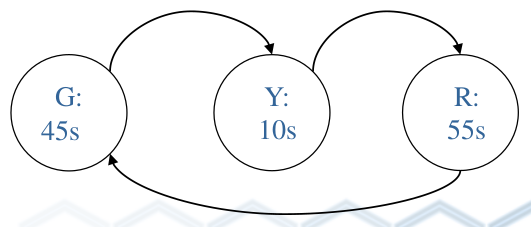</center>

Descargar el modelo `semaforo` del _Campus_ de la materia y ubicarlo en la carpeta `examples`.

### Modelo: modelo acoplado y componentes

El comportamiento del modelo está especificado mediante el modelo atómico DEVS: `TrafficLights`.

Pasamos como parámetros los tiempos de cada color:
* Tiempo en verde (_t_green_)
* Tiempo en amarillo (_t_yellow_)
* Tiempo en rojo (_t_red_)

Veamos el contenido del archivo `trafficlights.ma`:

In [32]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/semaforo/model/

cat trafficlights.ma

[top]

components : semaforo@TrafficLights
out : out_port

link : out@semaforo out_port

[semaforo]
t_green : 45
t_yellow : 10
t_red : 55


### Simulador CD++

Acá registramos el modelo atómico `TrafficLights` en una instancia del simulador CD++ y compilamos a este último:

In [34]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/semaforo/src/
#pwd

make clean

make -j4

g++ -c -I../../../src/cd++/warped -I../../../src/cd++/warped/notime -I../../../src/cd++/warped/notime/obj -I../../../src/cd++/warped/common -I../../../src/cd++/warped/common/obj -I../../../src/cd++/val -I../../../src/cd++/val/obj -I../../../src/cd++/atomics -I../../../src/cd++/atomics/generator -I../../../src/cd++/atomics/generator/obj -I../../../src/cd++/atomics/qss -I../../../src/cd++/atomics/qss/obj -I../../../src/cd++/atomics/transducer -I../../../src/cd++/atomics/transducer/obj -I../../../src/cd++/atomics/cpu -I../../../src/cd++/atomics/cpu/obj -I../../../src/cd++/atomics/queue -I../../../src/cd++/atomics/queue/obj -I../../../src/cd++/model -I../../../src/cd++/model/obj -I../../../src/cd++/model/state -I../../../src/cd++/model/state/obj -I../../../src/cd++/proc -I../../../src/cd++/proc/obj -I../../../src/cd++/proc/state -I../../../src/cd++/proc/state/obj -I../../../src/cd++/msg -I../../../src/cd++/msg/obj -I../../../src/cd++/sim -I../../../src/cd++/sim/loader -I../../../src/cd++/s

/usr/bin/ld: /home/gisela/SED/CDPP_ExtendedStates-codename-Santi/examples/semaforo/src/bin/libsimu.a(macroexp.o): en la función `macroExpansion::expand[abi:cxx11]()':
/home/gisela/SED/CDPP_ExtendedStates-codename-Santi/src/cd++/utils/macroexp.cpp:147: aviso: the use of `tmpnam' is dangerous, better use `mkstemp'
/usr/bin/ld: warped/notime/obj/DebugStream.o: en la función `DebugStream::interact()':
/home/gisela/SED/CDPP_ExtendedStates-codename-Santi/src/cd++/warped/notime/DebugStream.cpp:682: aviso: the `gets' function is dangerous and should not be used.


### Simulación del modelo con CD++

Ahora nos paramos en donde se encuentra el ejecutable de la simulación y corremos la simulación:

In [35]:
%%bash -s "$CDPP_EXAMPLES"

# prueba de que anduvo bien la compilación:

cd $1/semaforo/src/

bin/cd++ -m ../model/trafficlights.ma \
         -o ../trafficlights.out \
         -l ../trafficlights.log \
         -t 00:03:00:00

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/trafficlights.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../trafficlights.log
Output to: ../trafficlights.out
Tolerance set to: 1e-08
Configuration to show real num

### Análisis de los resultados

Veamos el resultado:

In [36]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/semaforo/

cat trafficlights.out

00:00:00:000:0 out_port      3.00000
00:00:45:000:0 out_port      1.00000
00:00:55:000:0 out_port      2.00000
00:01:50:000:0 out_port      3.00000
00:02:35:000:0 out_port      1.00000
00:02:45:000:0 out_port      2.00000


In [48]:
# definimos los path a los archivos de interés
OUT_FILENAME   = str(CDPP_EXAMPLES)+'/semaforo/trafficlights.out'

# armamos el dataframe
salida = pd.read_csv(OUT_FILENAME,
                     delimiter=r'(?<!,)\s+',
                     engine='python',  # C engine doesnt work for regex
                     converters=df_converters,
                     names=[TIME_COL, PORT_COL, VALUE_COL]
                    )

In [49]:
# graficamos usando la nueva libreria
# dejo seteado para que se muestre un grafico de barras mostrando los valores obtenidos a cada instante de tiempo
pivot_ui(salida,
         cols= [TIME_COL], # eje de abscisas
         rows= [VALUE_COL], # eje de coordenadas
         rendererName= "Bar Chart", # grafico de barras
         aggregatorName= "List Unique Values", # agregacion para ver valores
         vals= [VALUE_COL] # valores sobre los que se aplica la agregacion
        
        )

En este gráfico se observan los momentos en los que se cambia a cada color del semáforo (los colores del gráfico por default no se corresponden con un semáforo, considerar al 1 como verde, al 2 como amarillo y al 3 como rojo). Notar que al pasar el puntero del mouse sobre cada barra, se muestran los valores correspondientes.

Se sugiere jugar con la interfaz para ver otras visualizaciones sobre los mismos datos.

## Modelo _Simple Network_

### Descripción del modelo

* El modelo más simple de la red es considerarla como un **retardo**: cada mensaje que llega es retardado en una cantidad de tiempo.
* Existe una dada probabilidad que un mensaje sea descartado en algún lugar de la red ($50$% de probabilidad).

<center></center>

Descargar el modelo `simpleNetwork` del _Campus_ de la materia y ubicarlo en la carpeta `examples`. 

### Modelo: modelo acoplado y componentes

Para este modelo vamos a considerar dos submodelos:

* Modelo generador de tráfico
* Modelo de la red (retardo fijo)

Para el generador vamos a reutilizar el modelo atómico DEVS `Generator` que utilizamos anteriormente para generar los mensajes que queremos transmitir con una tasa constante.

Para el modelo de la red propiamente dicha utilizaremos un retardo con el modelo atómico `networkDelayType`. Este modelo tiene dos puertos de entrada y uno de salida:

* puerto entrada 0: otra para los mensajes: `in`. 
* puerto entrada 1: para configurar el retardo: `set_delay` 
* puerto de salida: donde salen los mensajes demorados: `out`

Además tiene un parámetro para configuar el valor inicial del retardo: `initialDelay`.

En este ejemplo vamos a utilizar un modelo atómico DEVS para el generador (`TrafficGenerator`) y un modelo acoplado DEVS para la red (`network`). Este modelo acoplado contiene un único modelo atómico DEVS (`networkDelayType`).

<center></center>

In [50]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/SimpleNetwork/model/

cat simpleNetwork.ma

[Top]
components : TrafficGenerator@Generator network 
out : out generator_out 
in : setNetworkDelay 
Link : setNetworkDelay setDelay@network
Link : out@TrafficGenerator in@network
Link : out@TrafficGenerator generator_out
Link : out@network out

[TrafficGenerator]
distribution : Constant
value : 10
initial : 0
increment : 1

[network]
components : networkDelay@networkDelayType 
out : out 
in : in setDelay 
Link : in in@networkDelay
Link : setDelay setDelay@networkDelay
Link : out@networkDelay out

[networkDelay]
initialDelay : 5





### Simulador CD++

A continuación registramos el nuevo modelo atómico `networkDelayType` en una instancia local del simulador y lo compilamos:

In [53]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/SimpleNetwork/src/
make clean
make -j4

g++ -c -I../../../src/cd++/warped -I../../../src/cd++/warped/notime -I../../../src/cd++/warped/notime/obj -I../../../src/cd++/warped/common -I../../../src/cd++/warped/common/obj -I../../../src/cd++/val -I../../../src/cd++/val/obj -I../../../src/cd++/atomics -I../../../src/cd++/atomics/generator -I../../../src/cd++/atomics/generator/obj -I../../../src/cd++/atomics/qss -I../../../src/cd++/atomics/qss/obj -I../../../src/cd++/atomics/transducer -I../../../src/cd++/atomics/transducer/obj -I../../../src/cd++/atomics/cpu -I../../../src/cd++/atomics/cpu/obj -I../../../src/cd++/atomics/queue -I../../../src/cd++/atomics/queue/obj -I../../../src/cd++/model -I../../../src/cd++/model/obj -I../../../src/cd++/model/state -I../../../src/cd++/model/state/obj -I../../../src/cd++/proc -I../../../src/cd++/proc/obj -I../../../src/cd++/proc/state -I../../../src/cd++/proc/state/obj -I../../../src/cd++/msg -I../../../src/cd++/msg/obj -I../../../src/cd++/sim -I../../../src/cd++/sim/loader -I../../../src/cd++/s

In file included from networkDelayType.cpp:20:
networkDelayType.h: In constructor ‘networkDelayType::networkDelayType(const string&)’:
networkDelayType.h:40:10: warning: ‘networkDelayType::out’ will be initialized after [-Wreorder]
   40 |    Port &out ;    // this is an output port named 'out'
      |          ^~~
networkDelayType.h:38:16: warning:   ‘const Port& networkDelayType::in’ [-Wreorder]
   38 |    const Port &in; // this is an input port named 'in'
      |                ^~
networkDelayType.cpp:41:1: warning:   when initialized here [-Wreorder]
   41 | networkDelayType::networkDelayType( const string &name ) :
      | ^~~~~~~~~~~~~~~~
/usr/bin/ld: /home/gisela/SED/CDPP_ExtendedStates-codename-Santi/examples/SimpleNetwork/src/bin/libsimu.a(macroexp.o): en la función `macroExpansion::expand[abi:cxx11]()':
/home/gisela/SED/CDPP_ExtendedStates-codename-Santi/src/cd++/utils/macroexp.cpp:147: aviso: the use of `tmpnam' is dangerous, better use `mkstemp'
/usr/bin/ld: warped/notime/

### Simulación del modelo con CD++

Ahora nos paramos en donde se encuentra el ejecutable del simulador y corremos $20~\text{s}$ de la simulación:

In [54]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/SimpleNetwork/src/

bin/cd++ -m ../model/simpleNetwork.ma \
         -l ../simpleNetwork.log \
         -o ../simpleNetwork.out \
         -t 00:02:00:00

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/simpleNetwork.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../simpleNetwork.log
Output to: ../simpleNetwork.out
Tolerance set to: 1e-08
Configuration to show real num

### Análisis de los resultados

Ahora veamos los resultados:

In [59]:
OUT_FILENAME = str(CDPP_EXAMPLES)+"/SimpleNetwork/simpleNetwork.out"

salida = pd.read_csv(OUT_FILENAME,
                     delimiter=r'(?<!,)\s+',
                     engine='python',  # C engine doesnt work for regex
                     converters=df_converters,
                     names=[TIME_COL, PORT_COL, VALUE_COL]
                    )

In [58]:
# graficamos usando la nueva libreria
# dejo seteado para que se muestre un grafico de barras apiladas mostrando los puertos por los que salen mensajes para cada mensaje de la red
pivot_ui(salida,
        cols= [VALUE_COL],
         rows= [PORT_COL],
         rendererName= "Stacked Bar Chart",
         aggregatorName= "List Unique Values",
         vals= [TIME_COL]
        
        )

En el gráfico obtenido podemos observar que:

* Algunos mensajes enviados por la red se pierden.
* Los mensajes obtenidos a la salida de la red están retardados en 5 s.
* El valor de los mensajes arranca en 0 y se va incrementando de uno en uno.

Se sugiere jugar con la interfaz para ver otras visualizaciones sobre los mismos datos.

## Modelo de un transductor

### Descripción del modelo (modelo conceptual)

Un modelo simple del comportamiento de un transductor (que vieron en la teórica) es el siguiente: 

* Al modelo llegan dos eventos de entrada

* El modelo se encarga de contar la cantidad de trabajos finalizados en una dada unidad de tiempo.
* Este calcula el _ratio_ de uso del servidor (una CPU en este caso): 
$$
\frac{\sum_i \text{trabajos}_i}{\text{tiempo}}
$$
* Saca los resultados por las salidas con una dada frecuencia.

Este modelo cuenta con dos entradas:

* Trabajos arribados (`arrived`)
* Trabajos procesados (`solved`)

y dos salidas que se actualizan de forma periódica (dado por el parámetro `frecuence`):

* Tasa de trabajos procesados por unidad de tiempo (`throughput`)
* Uso del procesador (`cpuUsage`)

 <center></center>

Este modelo tiene **dos puertos de entrada** de eventos y **dos puertos de salida** de eventos.

Descargar el modelo `transducer` del _Campus_ de la materia y ubicarlo en la carpeta `examples`. 

### Modelo: modelo acoplado y componentes

<center></center>

In [60]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/transducer/

cat transduc.ma

[top]

components : trans@transducer

out : cpuusage_port throughput_port
in : arrived_port solved_port

link : arrived_port arrived@trans
link : solved_port solved@trans
link : cpuusage@trans cpuusage_port
link : throughput@trans throughput_port

[trans]


### Simulador CD++

Este modelo ya viene con CD++, y por lo tanto no es necesario registrarlo ni compilar una instancia local del simulador.

### Simulación del modelo con CD++

Necesitamos un archivo de eventos de entrada para verificar el funcionamiento de este modelo atómico.

Definimos 4 eventos de entrada:
* Puerto _arrived_ 
  * tiempo = 10s, valor = 1
  * tiempo = 35s, valor = 2
  * tiempo = 45s, valor = 3
* Evento por el puerto _solved_ 
  * tiempo = 1min 21s, valor = 1

Vamos a generar estos eventos con el archivo `transduc.ev`. El formato de los eventos en este archivo es:
```
<tiempo> <puerto> <valor>
```

In [61]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/transducer/

cat transduc.ev

00:00:10:00 arrived_port 1
00:00:35:00 arrived_port 2
00:00:45:00 arrived_port 3
00:01:21:00 solved_port 1


Para simularlo utilizaremos la instancia del simulador en `src/bin/`:

In [62]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/transducer/

../../src/bin/cd++ -m transduc.ma  \
               -e transduc.ev  \
               -o transduc.out \
               -l transduc.log \
               -t 00:10:00:00

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from transduc.ma
Loading events from transduc.ev
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: transduc.log
Output to: transduc.out
Tolerance set to: 1e-08
Configuration to show real numbers: Width = 12 - 

### Análisis de los resultados

A continuación carguemos los archivos de log en un dataframe para analizar posteriormente:

In [80]:
LOG_FILENAME = str(CDPP_EXAMPLES)+"/transducer/transduc.log"

# definimos los nombres de las columnas en los dataframes de pandas
TIME_COL = 'time'
PORT_COL = 'port'
VALUE_COL = 'value'
MESSAGE_TYPE_COL = 'message_type'
MODEL_ORIGIN_COL = 'model_origin'
MODEL_DEST_COL = 'model_dest'

log_file_per_component = {}
parsed_logs = {}

with open(LOG_FILENAME, 'r') as main_log_file:
    main_log_file.readline()  # Ignore first line
    log_dir = os.path.dirname(LOG_FILENAME)
    for line in main_log_file:
        name, path = line.strip().split(' : ')
        log_file_per_component[name] = (path if os.path.isabs(path) else
                                        log_dir + '/' + path.split('/')[-1])

df_converters = {
    #VALUE_COL: parse_value,
    TIME_COL: time_to_secs
}
    
for logname, filename in log_file_per_component.items():
    parsed_logs[logname] = pd.read_csv(filename,
                                       delimiter=r' /\s+',
                                       engine='python',  # C engine doesnt work for regex
                                       converters=df_converters,
                                       names=[0, 1,  # Not sure what first two cols are
                                              MESSAGE_TYPE_COL,
                                              TIME_COL,
                                              MODEL_ORIGIN_COL,
                                              PORT_COL,
                                              VALUE_COL,
                                              MODEL_DEST_COL]
                                      )

df_top = parsed_logs["top"]


In [84]:
pivot_ui(df_top,
        rows= [TIME_COL,MODEL_ORIGIN_COL,VALUE_COL,PORT_COL],
        rendererName= "Table",
        aggregatorName= "Count"
        )

Luego de ejecutar la celda anterior, filtrar en la interfaz gráfica el campo `message_type` por el valor D (esto se hace desplegando dicho campo). Los **mensajes D** (_done_) llevan información del agendamiento de futuros eventos internos. Atender a que el nombre de cada columna del dataframe no necesariamente se corresponde con el contenido, pues cada tipo de mensaje muestra distintos datos (la forma de obtener el dataframe está tomado de las clases).

Podemos notar varias cosas:
* Los mensajes se originan en el atómico `trans` y llegan al acoplado `top` que lo contiene.
* En el instante $0$ se agenda el próximo evento interno en $1~\text{min}$.
* Cada vez que llega un evento externo ($10~\text{s}$, $35~\text{s}$ y $45~\text{s}$) se agenda un próximo evento interno en el instante que sale de la diferencia entre $1~\text{min}$ y el instante en que arriba el evento externo.

# Conclusiones

La librería pivottablejs para python nos permite, dentro del notebook, explorar dataframes de manera práctica a través de una interfaz gráfica con drag and drop, ahorrándonos el tiempo de trabajar los dataframes "a mano" para obtener visualizaciones significativas.

Es de notar, sin embargo, que su uso no es intuitivo en primera instancia, y requiere algo de práctica interpretar cómo cada tipo de tabla o gráfico ubica los datos indicados.